# Workflow Profiling

This notebook discusses the use of the `monai.utils.WorkflowProfiler` used to gather information about time requirements of various parts of your workflow. This will cover assessing the time spent in transforms, generating batches, training forward and backward passes, etc. This class gathers information using tracing about what functions/methods are called as well as marking explicit constructs to profile, such as callables and context blocks. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/workflow_profiling.ipynb)

First thing to do is setup environment and imports:

In [ ]:
!python -c "import monai" || pip install -q monai-weekly

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import matplotlib.pyplot as plt

import monai
from monai.config import print_config
from monai.data import Dataset, create_test_image_3d, DataLoader, ThreadDataLoader
from monai.handlers import MeanDice
from monai.losses import DiceLoss
from monai.networks.nets import UNet
import monai.transforms as mt
from monai.utils import first, WorkflowProfiler, ProfileHandler
from monai.utils.enums import CommonKeys

import torch

print_config()

MONAI version: 0.9.1rc4+25.gcef5c23f.dirty
Numpy version: 1.21.2
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cef5c23f14d9142b6c0953b1a84ce5ff953c8a25
MONAI __file__: /home/localek10/workspace/monai/MONAI_mine/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: 4.5.1
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.5
einops version: 0.4.0
transformers version: 4.14.1
mlflow version: 1.23.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Profiling Components

The `WorkflowProfiler` defines a context manager which is used to start and stop its internal results reading thread and configure tracing. Typically all profiling should be done with the context otherwise the results may not be read and so won't appear in the summary. Methods of this class are provided to create separate context blocks used to time how long it takes to enter and exit, wrappers around callables to time how long calls take, and iterables to time how long item generation takes.

Here the test synthetic dataset is created within such a context to demonstrate using sub-blocks to time parts of a workflow and wrapping callables:

In [2]:
dataset=[]
num_items=30
im_shape=(128, 128, 128)

# create the profiler using None to disable tracing for now
with WorkflowProfiler(call_selector=None) as wp:
    # wrap create_test_image_3d in a function which will log how long invocations take
    gen_func=wp.profile_callable("Data generation func")(create_test_image_3d)

    # enclose code in this context which recalls how long execution took
    with wp.profile_ctx("Generation loop"):
        for _ in range(num_items):
            img, seg = gen_func(*im_shape, num_seg_classes=1)

            dataset.append({CommonKeys.IMAGE: img, CommonKeys.LABEL: seg})
        
print(wp.get_times_summary())

{'Data generation func': (30, 2.879482288, 0.09598274293333334, 0.0043424045716563, 0.09295524000000001, 0.11674962400000001), 'Generation loop': (1, 3.221311667, 3.221311667, 0.0, 3.221311667, 3.221311667)}


The times summary this produced isn't terribly legible in this form so let's use Pandas to make a nice table in Jupyter:

In [3]:
wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Generation loop,1,3.221312,3.221312,0.000000,3.221312,3.221312
Data generation func,30,2.879482,0.095983,0.004342,0.092955,0.116750


This gives time summaries for the two constructs that were profiled. The "Generation loop" context was entered only once while the "Data generation func" (which was `create_test_image_3d` wrapped in another callable) was called multiple times. A context can be entered and exited multiple times, and multiple different context blocks can have the same name thus accumulating results in one place. 

The raw results can be queried with `get_results` which ensures thread and process safety. This should be called outside the enclosing context to ensure that thread finalisation has taken place before results are gathered. 

In [4]:
results=wp.get_results()
print(results)

{'Data generation func': (ProfileResult(name='Data generation func', time=116749624, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2696250, timestamp='2022-08-02 19:11:25.918124'), ProfileResult(name='Data generation func', time=101194761, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2696250, timestamp='2022-08-02 19:11:26.031237'), ProfileResult(name='Data generation func', time=99070561, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2696250, timestamp='2022-08-02 19:11:26.143199'), ProfileResult(name='Data generation func', time=96207496, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2696250, timestamp='2022-08-02 19:11:26.251346'), ProfileResult(name='Data generation func', time=96883471, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2696250, timestam

The result is a dictionary relating construct names to a list of invocations. Each call or execution of a construct produces a `ProfileResult` object to store information about the call, specifically `time` records how many nanoseconds were taken. Stack inspection and tracing is used to, as best as possible, record where the invocation was in code. The PID is also recorded since results can be collected from subprocesses when `DataLoader` objects are used with process workers. 

## Transform Profiling

Profiling how long each transform takes when executing a pipeline is complex owing to difficulting in determining when a transform runs, what times are taken, what transforms call others, etc. The `WorkflowProfiler` class uses tracing to profile all function/method calls matching a given criteria. In the previous example the criteria function was `None` to disable tracing, however the default is a function which selects only the `__call__` methods of `Transforms` instances. This includes top-level transforms and those called by others, but gives a useful idea of time taken relative to one another. Note that tracing is expensive so the times given are not real-world times but are still useful to identify which transform is expensive. 

(1, 128, 128, 128) torch.float32
(1, 128, 128, 128) torch.float32


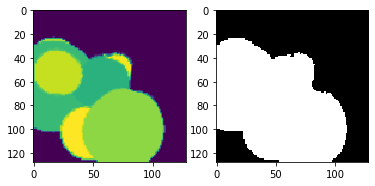

In [5]:
both_keys=(CommonKeys.IMAGE,CommonKeys.LABEL)
rand_prob=0.5

trans=[
    mt.AddChanneld(both_keys),
    mt.RandSpatialCropd(both_keys,(96, 96, 96), random_size=False),
    mt.ScaleIntensityd(CommonKeys.IMAGE),
    mt.RandAxisFlipd(both_keys,rand_prob),
    mt.RandRotate90d(both_keys, prob=rand_prob, spatial_axes=[0, 1]),
    mt.RandSmoothDeformd(
        keys=both_keys,
        spatial_size=im_shape,
        rand_size=(3,3,3),
        pad=2,
        def_range=0.1,
        field_mode=monai.utils.InterpolateMode.TRILINEAR,
        grid_mode=(monai.utils.GridSampleMode.BILINEAR,monai.utils.GridSampleMode.NEAREST),
        align_corners=True,
        prob=1.0,
    ),
    mt.EnsureTyped(both_keys,dtype=(np.float32, np.int32)),
]

train_trans=mt.Compose(trans)

with WorkflowProfiler() as wp:
    test=train_trans(dataset[0])

print(test[CommonKeys.IMAGE].shape,test[CommonKeys.IMAGE].dtype)
print(test[CommonKeys.LABEL].shape,test[CommonKeys.LABEL].dtype)

fig,(ax0,ax1) = plt.subplots(1,2)
ax0.imshow(test[CommonKeys.IMAGE][0,48],interpolation="none")
ax1.imshow(test[CommonKeys.LABEL][0,48],interpolation="none",cmap="gray")

The results is now populated with calls to the `__call__` methods of every transform mentioned above and all those they use. Although tracing has high overhead this still demonstrates that `RandSmoothDeformd` (which uses `RandSmoothDeform`) is the slowest transform defined above by a large margin. Many transforms have very fast total time if by chance they were skipped since their `prob` arguments are less than 1.0. For multiple runs of the same sequence, ie. when generating a whole batch, the results will be more indicative of the time proportion each transform uses. 

In [6]:
wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Compose.__call__,1,0.354461,0.354461,0.000000,0.354461,0.354461
RandSmoothDeformd.__call__,1,0.332621,0.332621,0.000000,0.332621,0.332621
RandSmoothDeform.__call__,2,0.332094,0.166047,0.057586,0.108462,0.223633
RandSpatialCrop.__call__,4,0.009523,0.002381,0.000788,0.001536,0.003223
RandRotate90d.__call__,1,0.007078,0.007078,0.000000,0.007078,0.007078
Rotate90.__call__,2,0.006132,0.003066,0.000080,0.002986,0.003146
RandSpatialCropd.__call__,1,0.005504,0.005504,0.000000,0.005504,0.005504
ScaleIntensityd.__call__,1,0.004298,0.004298,0.000000,0.004298,0.004298
ScaleIntensity.__call__,1,0.004068,0.004068,0.000000,0.004068,0.004068
RandAxisFlipd.__call__,1,0.001789,0.001789,0.000000,0.001789,0.001789


The call selection function can be substituted with any callable which accepts a `frame` object used by `sys.settrace` and `threading.settrace` and returns `True` if the call the frame represents should be traced. The default inspects the frame and returns true if the call is `__call__` and the receiver is a `Transform` instance:

```python
def select_transform_call(frame):
    """Returns True if `frame` is a call to a `Transform` object's `_call__` method."""
    from monai.transforms import Transform  # prevents circular import

    self_obj = frame.f_locals.get("self", None)
    return frame.f_code.co_name == "__call__" and isinstance(self_obj, Transform)
```

You can provide your own criteria functions to replace this one, just don't provide one which traces all calls since this will lead to infinite recursion and be incredibly slow even if that was avoided.

An alternative function to trace only nominated objects may be more useful to narrow the scope of the trace to top-level transforms only: 

In [7]:
class TraceObjectsOnly:
    def __init__(self, objects):
        self.objects=objects
        
    def __call__(self, frame):
        self_obj = frame.f_locals.get("self", None)
        return frame.f_code.co_name == "__call__" and self_obj in self.objects
    
    
# `trans` is the list of transforms defined above, not the Compose object
with WorkflowProfiler(TraceObjectsOnly(trans)) as wp:
    test=train_trans(dataset[0])
    
wp.get_times_summary_pd()  # much more concise view of what's going on

,Count,Total Time (s),Avg,Std,Min,Max
RandSmoothDeformd.__call__,1,0.239953,0.239953,0.0,0.239953,0.239953
ScaleIntensityd.__call__,1,0.004941,0.004941,0.0,0.004941,0.004941
RandSpatialCropd.__call__,1,0.004205,0.004205,0.0,0.004205,0.004205
RandAxisFlipd.__call__,1,0.001931,0.001931,0.0,0.001931,0.001931
AddChanneld.__call__,1,0.001544,0.001544,0.0,0.001544,0.001544
RandRotate90d.__call__,1,0.000953,0.000953,0.0,0.000953,0.000953
EnsureTyped.__call__,1,0.000949,0.000949,0.0,0.000949,0.000949


## Whole Workflow Profiling

These elements can now be combined to profile all the aspects of the typically Pytorch training workflow:

In [8]:
device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_func = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)
num_epochs=3
batch_size=5


with WorkflowProfiler(TraceObjectsOnly(trans)) as wp:
    # profile how long it takes to create the dataset and loader, this could be long for different dataset types
    with wp.profile_ctx("Create DataLoader"):
        ds=Dataset(dataset,train_trans)
        dl=DataLoader(ds, batch_size=batch_size, num_workers=4)
        
    # break passes into functions which can be decorated, context blocks in the training loop could be used instead
    
    @wp.profile_callable()
    def forward_pass(batch):
        img=batch[CommonKeys.IMAGE].to(device)
        seg=batch[CommonKeys.LABEL].to(device)
        
        return net(img), seg
    
    @wp.profile_callable()
    def backward_pass(pred,seg):
        loss=loss_func(pred,seg)
        loss.backward()
        return loss
        
    for epoch in range(1,1+num_epochs):
        print("Epoch",epoch)
        
        # allows measuring how long each epoch takes
        with wp.profile_ctx("Epoch"):
            # measures how long batch generation takes
            for batch in wp.profile_iter("Batch generation",dl):
                opt.zero_grad()
                pred,seg=forward_pass(batch)
                loss=backward_pass(pred,seg)
                opt.step()
                print(loss.item())
                
wp.get_times_summary_pd()

Epoch 1
0.6848792433738708
0.5431780219078064
0.3928299844264984
0.4282590448856354
0.4006887376308441
0.409665584564209
Epoch 2
0.44062066078186035
0.410720556974411
0.3176608681678772
0.37237992882728577
0.3969933092594147
0.356233686208725
Epoch 3
0.41888055205345154
0.4264364242553711
0.312073677778244
0.36187681555747986
0.39938220381736755
0.36514243483543396


,Count,Total Time (s),Avg,Std,Min,Max
RandSmoothDeformd.__call__,90,27.281915,0.303132,0.023752,0.244326,0.345424
Epoch,3,12.274654,4.091551,0.057460,4.023440,4.163989
Batch generation,18,6.017345,0.334297,0.587337,0.000070,1.581438
forward_pass,18,1.656790,0.092044,0.182303,0.045723,0.843641
backward_pass,18,1.448207,0.080456,0.003903,0.077630,0.092366
ScaleIntensityd.__call__,90,0.463454,0.005149,0.002686,0.003256,0.013807
RandRotate90d.__call__,90,0.234174,0.002602,0.002321,0.000413,0.010736
RandSpatialCropd.__call__,90,0.200788,0.002231,0.001762,0.001401,0.010297
RandAxisFlipd.__call__,90,0.190194,0.002113,0.001611,0.000484,0.006317
EnsureTyped.__call__,90,0.163245,0.001814,0.000142,0.001591,0.002466


Workflows using Ignite Engine classes can be profiled as well to get very similar results by using `ProfileHandler` to track certain pairs of events. In this example batch generation, iteration, and epoch time are measured using this handler in place of iterator and callable profiling:

In [9]:
from monai.engines import SupervisedTrainer
from ignite.engine import Events

device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_func = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)
num_epochs=3
batch_size=5

with WorkflowProfiler() as wp:
    with wp.profile_ctx("Create DataLoader"):
        ds=Dataset(dataset,train_trans)
        dl=DataLoader(ds, batch_size=batch_size, num_workers=4)
        
    trainer=SupervisedTrainer(
        device=device,
        max_epochs=num_epochs,
        train_data_loader=dl,
        network=net,
        optimizer=opt,
        loss_function=loss_func,
    )
    
    epoch_h=ProfileHandler("Epoch",wp, Events.EPOCH_STARTED, Events.EPOCH_COMPLETED).attach(trainer)
    iter_h=ProfileHandler("Iteration",wp, Events.ITERATION_STARTED, Events.ITERATION_COMPLETED).attach(trainer)
    batch_h=ProfileHandler("Batch generation",wp, Events.GET_BATCH_STARTED, Events.GET_BATCH_COMPLETED).attach(trainer)

    trainer.run()

wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Compose.__call__,90,27.432802,0.304809,0.027225,0.254590,0.369338
RandSmoothDeformd.__call__,90,25.935583,0.288173,0.026017,0.239692,0.342520
RandSmoothDeform.__call__,180,25.898198,0.143879,0.024117,0.102820,0.198502
Epoch,3,11.796939,3.932313,0.036529,3.894224,3.981581
Batch generation,18,6.944383,0.385799,0.697817,0.000102,2.050954
Iteration,18,2.726300,0.151461,0.008853,0.142024,0.176958
ScaleIntensityd.__call__,90,0.442524,0.004917,0.002115,0.003430,0.011568
ScaleIntensity.__call__,90,0.429266,0.004770,0.002103,0.003303,0.011389
RandSpatialCrop.__call__,360,0.413244,0.001148,0.000898,0.000692,0.006634
RandSpatialCropd.__call__,90,0.254404,0.002827,0.001680,0.001899,0.009951
